In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
import data
import models
import paths
import routine
import viz_tools

# Data

In [5]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in tqdm(dataset):
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def ToTensor(img):
    return torch.from_numpy(img).float().to(device)

LA5 rest absmax before normalization: 2767.815185546875
Dataset size: 147
Labels distribution: (array([0, 1]), array([119,  28]))

Example:
Image shape: torch.Size([16, 1, 51, 63, 43])
Target: 1


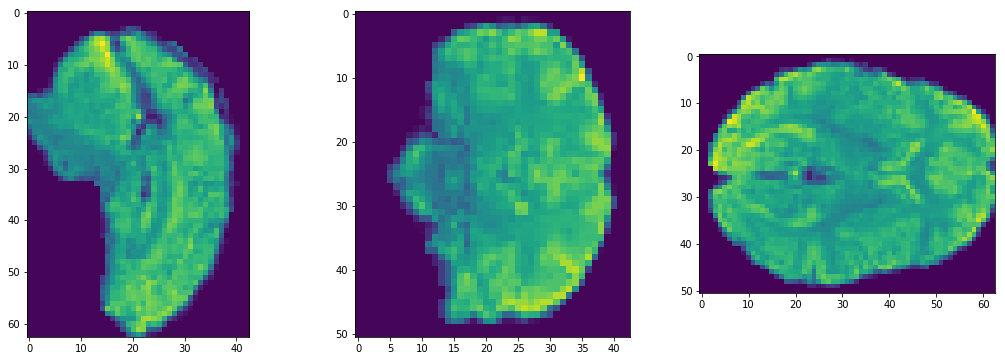

In [6]:
la5_rest_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.la5_rest_fmri_file_suffix,
    brain_mask_suffix=paths.la5_rest_fmri_brain_mask_suffix,
    coord_min=(7, 7, 0),
    img_shape=(51, 63, 43),
    seq_len=16,
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path,
)
la5_rest_absmax = 2767.815185546875 # 2442.174560546875 # get_absmax(la5_rest_dataset)
la5_rest_dataset.transform = transforms.Compose([
    ToTensor,
    functools.partial(AbsMaxScale, absmax=la5_rest_absmax),])
print("LA5 rest absmax before normalization: {}".format(la5_rest_absmax))
print("Dataset size: {}".format(len(la5_rest_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_rest_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_rest_dataset[-1]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img.cpu(), t=-1)

LA5 task absmax before normalization: 2767.815185546875
Dataset size: 147
Labels distribution: (array([0, 1]), array([120,  27]))

Example:
Image shape: torch.Size([16, 1, 51, 63, 43])
Target: 0


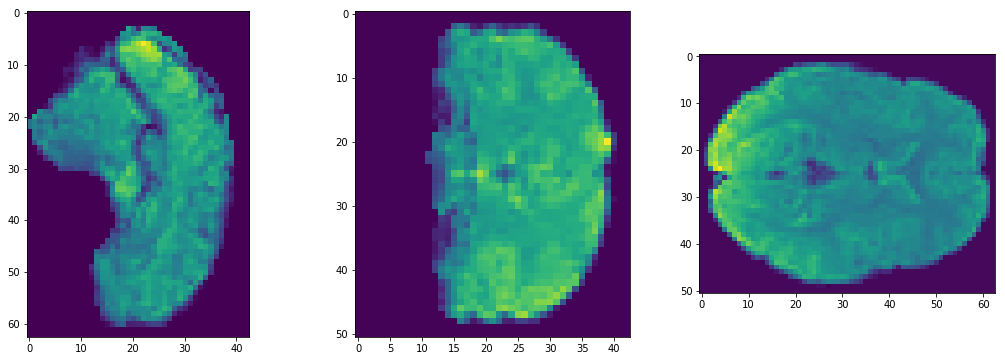

In [7]:
la5_task_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.la5_task_fmri_file_suffix,
    brain_mask_suffix=paths.la5_task_fmri_brain_mask_suffix,
    coord_min=(7, 7, 0),
    img_shape=(51, 63, 43),
    seq_len=16,
    problems=['Schz/Control'],
)
la5_task_absmax = 2767.815185546875 # get_absmax(la5_task_dataset)
la5_task_dataset.transform = transforms.Compose([
    ToTensor,
    functools.partial(AbsMaxScale, absmax=la5_task_absmax),])
print("LA5 task absmax before normalization: {}".format(la5_task_absmax))
print("Dataset size: {}".format(len(la5_task_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_task_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_task_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img.cpu(), t=-1)

Siblings absmax before normalization: 2698.230712890625
Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))

Example:
Image shape: torch.Size([16, 1, 51, 63, 43])
Target: 1


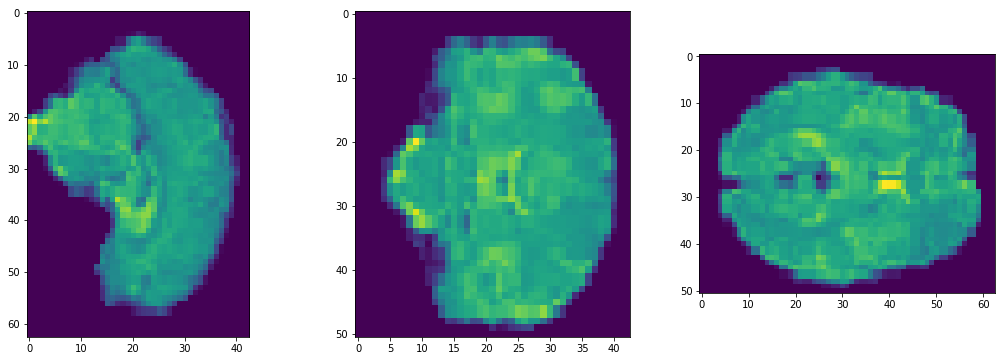

In [8]:
sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.sibl_fmri_file_suffix,
    brain_mask_suffix=paths.sibl_fmri_brain_mask_suffix,
    coord_min=(4,3,0),
    img_shape=(40,52,43),
    seq_len=16,
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
)
sibl_absmax = 2698.230712890625 # get_absmax(sibl_dataset)
sibl_dataset.transform = transforms.Compose([
    ToTensor,
    functools.partial(AbsMaxScale, absmax=sibl_absmax),
    functools.partial(torch.nn.functional.interpolate, size=la5_rest_dataset.img_shape, mode='nearest'),])
print("Siblings absmax before normalization: {}".format(sibl_absmax))
print("Dataset size: {}".format(len(sibl_dataset)))
print("Labels distribution: {}\n".format(np.unique(sibl_dataset.labels, return_counts=True)))

print("Example:")
img, target = sibl_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img.cpu(), t=-1)

# Model structure

In [18]:
def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False

    model = models.ConvLSTM(la5_rest_dataset.img_shape, n_outputs=2, hidden_size=128, n_layers=1,
                            n_fc_units_rnn=512, dropout=0, stride=1, n_filters=16, n_blocks=3)
    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        model.fc2 = torch.nn.Linear(512, 2)
        opt = torch.optim.Adam(model.fc2.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

# Train - LA5, Test - LA5

Epoch 22 of 100 took 124.529s
  training loss (in-iteration): 	0.025776
  validation loss: 			0.301825
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.85


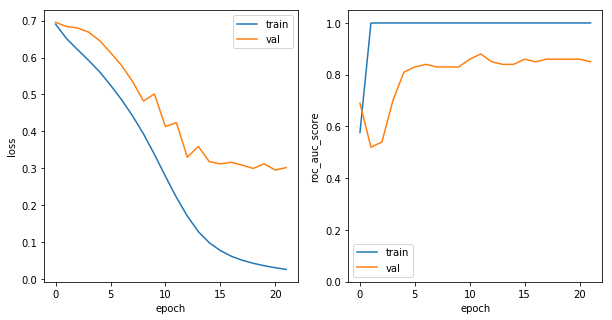

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.7469135802469137, 0.7777777777777778, 0.9135802469135802, 0.9615384615384615, 0.8799999999999999]
val roc_auc_score mean: 0.8559620132953466
val roc_auc_score std: 0.0812999477337037
CPU times: user 1h 46min 15s, sys: 1h 39min 14s, total: 3h 25min 29s
Wall time: 3h 40min 58s


In [10]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, la5_rest_dataset, cv, device, metric, batch_size=10, val_dataset=la5_task_dataset)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Train - Siblings, Test - Siblings

Epoch 11 of 100 took 19.472s
  training loss (in-iteration): 	0.556959
  validation loss: 			0.687838
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.62


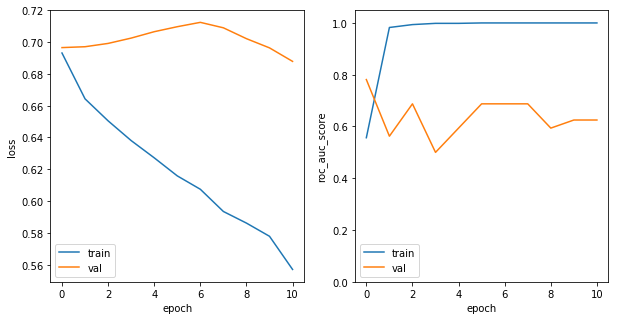

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.7333333333333334, 0.8250000000000001, 0.725, 0.96875, 0.78125]
val roc_auc_score mean: 0.8066666666666666
val roc_auc_score std: 0.08865703268463503
CPU times: user 10min 12s, sys: 15min 36s, total: 25min 49s
Wall time: 29min 46s


In [11]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Pretrain model on LA5 and save

In [12]:
model_save_path = "./models/conv_lstm_pretrained_la5.pth"

Epoch 15 of 15 took 72.865s
  training loss (in-iteration): 	0.050894
  training roc_auc_score: 			1.00


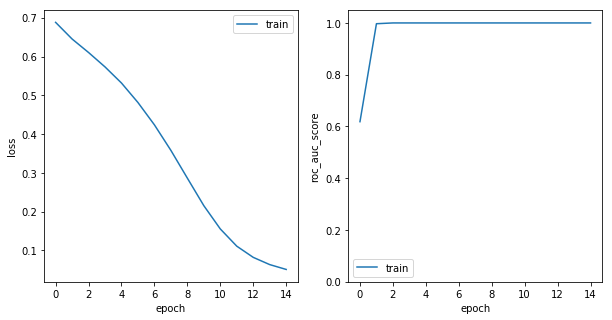

<Figure size 720x360 with 0 Axes>

CPU times: user 6min 27s, sys: 12min 13s, total: 18min 41s
Wall time: 30min 32s


In [13]:
%%time
model, optimizer = create_model_opt()
metric = roc_auc_score
train_idx = np.arange(len(la5_rest_dataset))
np.random.seed(0)
np.random.shuffle(train_idx)
train_idx = routine.stratified_batch_indices(train_idx, la5_rest_dataset.labels[train_idx])
train_loader = DataLoader(Subset(la5_rest_dataset, train_idx),
                          shuffle=False,
                          batch_size=10,
                          drop_last=False)
_ = routine.train(model, optimizer, train_loader, None, device, metric, verbose=1, model_save_path=model_save_path, max_epoch=15)

In [14]:
del model, optimizer, train_loader

# Pretrain - LA5, Test - Siblings

In [15]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      batch_size=10, model_load_path=model_save_path)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:16<00:00,  8.32s/it]

val roc_auc_scores: [0.575]
val roc_auc_score mean: 0.575
val roc_auc_score std: 0.0


# Pretrain - LA5, Train/Test - Siblings (fine tuning)

Epoch 19 of 100 took 21.669s
  training loss (in-iteration): 	0.144072
  validation loss: 			0.771634
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.60


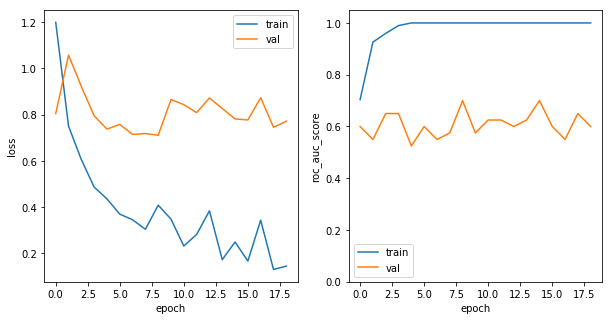

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.7]
val roc_auc_score mean: 0.7
val roc_auc_score std: 0.0
CPU times: user 2min 31s, sys: 4min 6s, total: 6min 38s
Wall time: 7min 36s


In [16]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      batch_size=10, model_load_path=model_save_path, finetune=True)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Pretrain - LA5, Train/Test - Siblings (transfer learning)

Epoch 13 of 100 took 16.138s
  training loss (in-iteration): 	0.684083
  validation loss: 			0.666897
  training roc_auc_score: 			0.70
  validation roc_auc_score: 			0.48


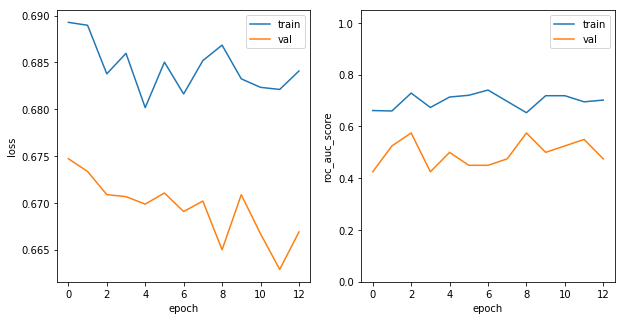

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.575]
val roc_auc_score mean: 0.575
val roc_auc_score std: 0.0
CPU times: user 1min 19s, sys: 2min 31s, total: 3min 50s
Wall time: 5min 22s


In [19]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      batch_size=10, model_load_path=model_save_path, transfer=True)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

# Conclusion

One can notice a significant drop in performance. This problem we aim to solve.